# Impact of the number of samples

In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
nbM = 10
nbA = 1
ages = [200, 400, 600, 800, 1000, 1200]
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)]
for a in ages:
    samples += [msprime.Sample(0,a) for i in np.arange(2*nbA)]

In [30]:
def run_sim(num_replicates, nbA, nbM, ages, samples):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne=15000, length= 2e2, samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM+nbA*len(ages),2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [36]:
g = allel.model.GenotypeArray(run_sim(190000, nbA, nbM, ages, samples))
g

<GenotypeArray shape=(93763, 16, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/1 0/0
0/0 0/0 1/1 0/1 0/1 ... 0/0 0/0 0/1 1/0 1/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/1 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/1 0/0 0/0 0/0
1/1 1/0 1/1 1/1 1/0 ... 1/1 1/1 1/1 1/1 1/1
0/0 0/0 0/1 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [41]:
gn = g.to_n_alt()[:,9:15]
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

(6, 6)

In [42]:
palette = sns.color_palette("hls", len(ages)+1)

colors = {
    'modern': palette[0],
}
for i in np.arange(len(ages)):
    colors[ages[i]] = palette[i+1]

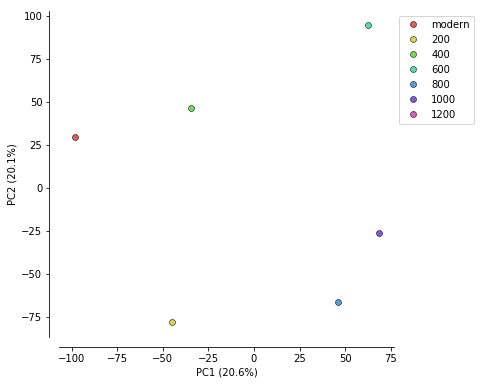

In [45]:
nbM = 1
def plot_pca_coords(coords, model, pc1, pc2, ax, ages):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors['modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=a,
            color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax, ages)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Text(0.5,1.02,'PC maps')

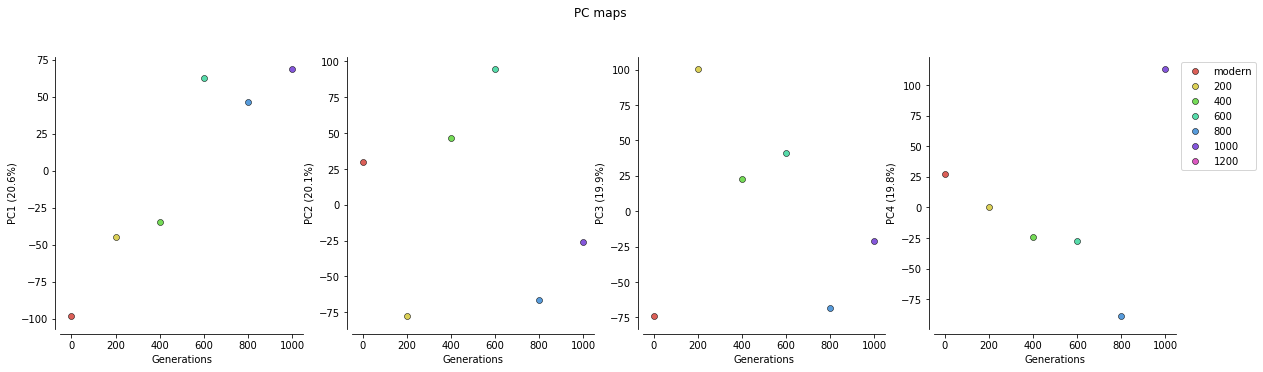

In [46]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    # modern samples
    y = coords[0:nbM, pc]
    x = np.zeros(len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors['modern'], markersize=6, mec='k', mew=.5)
    i = nbM
    l = nbM
    # ancient samples
    for a in ages:
        y = coords[i:i+nbA, pc]
        x = np.ones(len(y))
        ax.plot(x*a, y, marker='o', linestyle=' ', label=a, color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Generations')
    
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(1,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(1,4,4)
plot_PC_maps(coords, model, 3, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)